In [27]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from random import randint
import pandas as pd
import numpy as np
from tensorflow.keras import layers
from PIL import Image
from tensorflow.keras import regularizers
from tensorflow.keras import backend
from datetime import datetime

In [28]:
np.random.seed(42)

In [29]:
(x_train_valid, y_train_valid), (x_test, y_test) = keras.datasets.fashion_mnist.load_data() 

In [30]:
x_train, x_validation, y_train, y_validation = train_test_split(x_train_valid, y_train_valid, test_size=0.2, random_state=0)

x_train = x_train.astype("float32") / 255
x_validation = x_validation.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train.shape, x_validation.shape, x_test.shape

((48000, 28, 28), (12000, 28, 28), (10000, 28, 28))

In [31]:
x_train = x_train.reshape(-1, 784)
x_validation = x_validation.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

x_train.shape, x_validation.shape, x_test.shape

((48000, 784), (12000, 784), (10000, 784))

In [32]:
input_layer = Input(shape=(784,)) 
encoded = layers.Dense(32, activation='relu')(input_layer)
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# reconstruction model:
autoencoder = keras.Model(input_layer, decoded)

# encoder model:
encoder = keras.Model(input_layer, encoded)

# decoder model:
encoded_input = keras.Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]  # last layer of autoencoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [33]:
## input layer
input_layer = Input(shape=(784,)) 

## encoding architecture
encode_layer1 = Dense(128, activation='relu')(input_layer)
encode_layer2 = Dense(64, activation='relu')(encode_layer1)

## latent view
latent_view   = Dense(32, activation='sigmoid')(encode_layer2)

## decoding architecture
decode_layer1 = Dense(64, activation='relu')(latent_view)
decode_layer2 = Dense(128, activation='relu')(decode_layer1)

## output layer
output_layer  = Dense(784)(decode_layer2)

model = Model(input_layer, output_layer)

model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_25 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_26 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_27 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_28 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_29 (Dense)             (None, 784)               101

In [34]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=2048,
                shuffle=True,
                validation_data=(x_validation, x_validation))

Epoch 1/30
24/24 [==============================] - 1s 43ms/step - loss: 0.6305 - val_loss: 0.5365
Epoch 2/30
24/24 [==============================] - 1s 41ms/step - loss: 0.4969 - val_loss: 0.4596
Epoch 3/30
24/24 [==============================] - 1s 40ms/step - loss: 0.4361 - val_loss: 0.4149
Epoch 4/30
24/24 [==============================] - 1s 39ms/step - loss: 0.4045 - val_loss: 0.3946
Epoch 5/30
24/24 [==============================] - 1s 37ms/step - loss: 0.3878 - val_loss: 0.3805
Epoch 6/30
24/24 [==============================] - 1s 37ms/step - loss: 0.3750 - val_loss: 0.3689
Epoch 7/30
24/24 [==============================] - 1s 36ms/step - loss: 0.3642 - val_loss: 0.3591
Epoch 8/30
24/24 [==============================] - 1s 37ms/step - loss: 0.3552 - val_loss: 0.3510
Epoch 9/30
24/24 [==============================] - 1s 38ms/step - loss: 0.3480 - val_loss: 0.3446
Epoch 10/30
24/24 [==============================] - 1s 38ms/step - loss: 0.3422 - val_loss: 0.3396
Epoch 11/

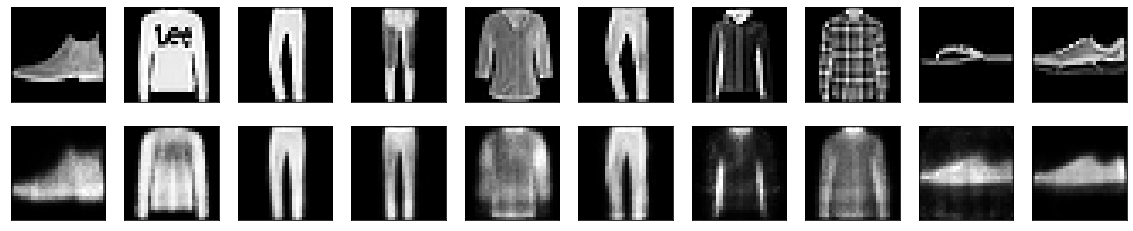

In [35]:
predictions = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# <b>Part 2 Noising and Denoising</b>

In [36]:
# shape back into image matrices
x_train = x_train.reshape(-1, 28, 28, 1)
x_validation = x_validation.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train.shape, x_validation.shape, x_test.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (10000, 28, 28, 1))

In [37]:
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_validation_noisy = x_validation + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_validation.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_validation_noisy = np.clip(x_validation_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

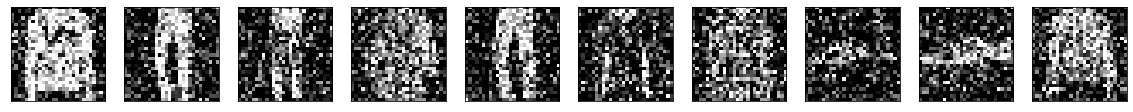

In [38]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [39]:
input_layer = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


model = Model(input_layer,decoded)

model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 32)        0  

In [40]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=30,
                batch_size=2048,
                shuffle=True,
                validation_data=(x_validation_noisy, x_validation))

Epoch 1/30
24/24 [==============================] - 39s 2s/step - loss: 0.5603 - val_loss: 0.3975
Epoch 2/30
24/24 [==============================] - 40s 2s/step - loss: 0.3569 - val_loss: 0.3364
Epoch 3/30
24/24 [==============================] - 39s 2s/step - loss: 0.3284 - val_loss: 0.3227
Epoch 4/30
24/24 [==============================] - 39s 2s/step - loss: 0.3194 - val_loss: 0.3155
Epoch 5/30
24/24 [==============================] - 39s 2s/step - loss: 0.3129 - val_loss: 0.3101
Epoch 6/30
24/24 [==============================] - 39s 2s/step - loss: 0.3085 - val_loss: 0.3065
Epoch 7/30
24/24 [==============================] - 39s 2s/step - loss: 0.3057 - val_loss: 0.3051
Epoch 8/30
24/24 [==============================] - 39s 2s/step - loss: 0.3038 - val_loss: 0.3036
Epoch 9/30
24/24 [==============================] - 39s 2s/step - loss: 0.3023 - val_loss: 0.3013
Epoch 10/30
24/24 [==============================] - 39s 2s/step - loss: 0.3013 - val_loss: 0.3004
Epoch 11/30
24/24 [

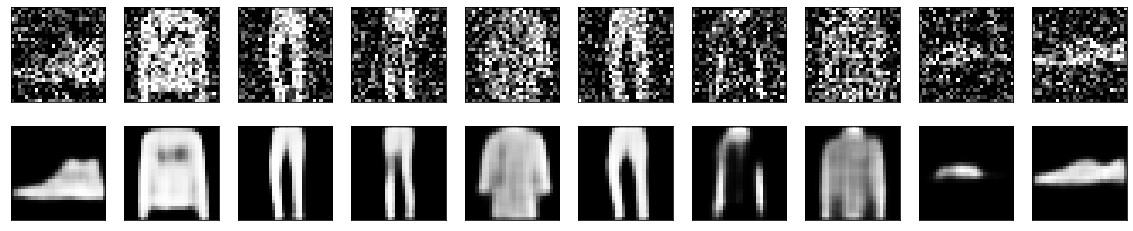

In [41]:
predictions = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # noisy
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()